In [1]:
from pandas.io.gbq import read_gbq
import pandas as pd

In [2]:
pd.options.display.max_rows = None

In [4]:
from bs4 import BeautifulSoup
import lxml
import pandas as pd
import requests

In [5]:
r=requests.get('https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm')
r.raise_for_status()
doc=BeautifulSoup(r.text,'lxml')

In [6]:
data={'borough': [], 'neighborhood': [], 'zip': []}
for row in doc.find('table').find_all('tr'):
    vals=[td.text.strip() for td in row.find_all('td')]
    if len(vals)==3:
        borough=vals.pop(0)
    if len(vals)==2:
        neighborhood, zips = vals
        for zipcode in zips.split(','):
            data['borough'].append(borough)
            data['neighborhood'].append(neighborhood)
            data['zip'].append(zipcode.strip())

In [7]:
neighborhoods_by_zip = pd.DataFrame(data).set_index('zip').sort_index()

In [8]:
neighborhoods_by_zip

,borough,neighborhood
zip,,
10001,Manhattan,Chelsea and Clinton
10002,Manhattan,Lower East Side
10003,Manhattan,Lower East Side
10004,Manhattan,Lower Manhattan
10005,Manhattan,Lower Manhattan
10006,Manhattan,Lower Manhattan
10007,Manhattan,Lower Manhattan
10009,Manhattan,Lower East Side
10010,Manhattan,Gramercy Park and Murray Hill


In [88]:
import fiona
import geopandas
import matplotlib.pyplot as plt
import shapely

In [159]:
import numpy as np

# Load ZCTA
We load the ZCTA shape files (unzipped from Columbia GIS zip file; replace with GeoJSON if preferred) here.  These have polygon boundaries associated with Census ZIP Code Tabulation Areas, geographic areas mostly corresponding to ZIP codes.

In [49]:
zcta = geopandas.read_file('nyu_2451_34509/nyu_2451_34509.shp')
zcta['geometry'].crs

{'datum': 'NAD83',
 'lat_0': 40.16666666666666,
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lon_0': -74,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 300000.0000000001,
 'y_0': 0}

The coordinate reference system above is important to note, since it's not latitude/longitude.  Since the MIT q scoresbelow will be lat/lon, we will need to convert to compare.

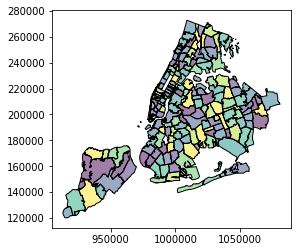

In [42]:
%matplotlib inline
zcta.plot()

In [51]:
zcta.head()

,bcode,geometry,note,zcta
0,36061,"POLYGON ((983229.2383424834 211922.5816751101,...",None,10001
1,36061,"POLYGON ((985096.3850784544 198703.5457405522,...",None,10002
2,36061,"POLYGON ((986450.4858028748 203647.5975069208,...",None,10003
3,36061,"(POLYGON ((976856.663963466 189102.0183191186,...",None,10004
4,36061,"POLYGON ((981746.6308157594 196240.0595342411,...",None,10005


# Load MIT street score

In [289]:
project = "spheric-crow-161317"
sample_query = """SELECT *
FROM `smart_cities_data.mit_streetscore`"""

mit_ss = read_gbq(query=sample_query, project_id=project, dialect='standard')

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 62% done. Elapsed 10.46 s.
  Got page: 3; 93% done. Elapsed 15.93 s.


Exception ignored in: <bound method Collection.__del__ of <open Collection '/home/nkrishna/agg_crime.json:OgrGeoJSON', mode 'w' at 0x7fa9482c2cf8>>
Traceback (most recent call last):
  File "/opt/anaconda/lib/python3.6/site-packages/fiona/collection.py", line 422, in __del__
    self.__exit__(None, None, None)
  File "/opt/anaconda/lib/python3.6/site-packages/fiona/collection.py", line 417, in __exit__
    self.close()
  File "/opt/anaconda/lib/python3.6/site-packages/fiona/collection.py", line 401, in close
    self.flush()
  File "/opt/anaconda/lib/python3.6/site-packages/fiona/collection.py", line 390, in flush
    if self.session is not None and self.session.get_length() > 0:
  File "fiona/ogrext.pyx", line 479, in fiona.ogrext.Session.get_length (fiona/ogrext.c:9611)
ValueError: Null layer


  Got page: 4; 100% done. Elapsed 17.12 s.
Got 322386 rows.

Total time taken 19.15 s.
Finished at 2017-03-25 22:19:33.


In [290]:
mit_ss=geopandas.GeoDataFrame(mit_ss)
mit_ss.head()

,latitude,longitude,q_score
0,40.595036,-74.107162,25.046595
1,40.644485,-74.107162,33.453838
2,40.636635,-74.107162,24.252043
3,40.611935,-74.107162,19.828709
4,40.562534,-74.107162,25.193838


The `Point`s should be constructed with longitude first; we will indicate that these are lon/lat by setting the CRS to WGS84, or EPSG 4326, then converting to EPSG 2263 (NAD83, same as ZCTA data)

In [291]:
ss=geopandas.GeoSeries(mit_ss.apply(lambda x: shapely.geometry.Point(x['longitude'],x['latitude']), axis=1))
ss.crs={'init': 'epsg:4326'}
mit_ss['geometry']=ss.to_crs(zcta.crs)
mit_ss.crs=zcta.crs

Join the q score with ZCTA to find the containing ZIP code for each row

In [292]:

joined=geopandas.sjoin(mit_ss,zcta.reset_index(),op='within')

In [293]:
joined = joined.set_index('zcta').sort_index()

Next use ZIP/ZCTA to add borough and neighborhood tags

In [294]:
enriched_df = joined.join(neighborhoods_by_zip)

We can aggregate and plot avg q score by ZIP code, eg

In [295]:
agg_q_score=zcta.set_index('zcta').sort_index().join(enriched_df.reset_index().groupby('level_0').agg({'q_score': np.mean}))
agg_q_score['q_score']=100-agg_q_score['q_score']

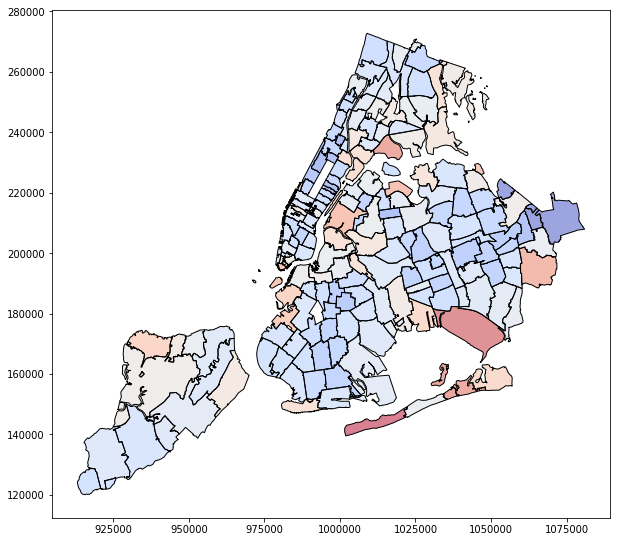

In [296]:
agg_q_score.plot(figsize=(10,10),column='q_score', cmap=plt.cm.coolwarm)

Now let's fold in crime data

In [297]:
project = "spheric-crow-161317"
sample_query = """SELECT PCT,crime_category,CRIME,_2014
FROM `smart_cities_data.NYPD_crime_stats_2000_2015`"""

crime = geopandas.GeoDataFrame(read_gbq(query=sample_query, project_id=project, dialect='standard'))

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 2695 rows.

Total time taken 0.82 s.
Finished at 2017-03-25 22:21:07.


In [298]:
precincts=geopandas.read_file('smart_cities/NYC_shapefiles/Police Precincts.geojson') 

In [299]:
precincts['precinct']=precincts['precinct'].astype('int64')

In [300]:
precincts['precinct'].dtype,crime['PCT'].dtype

(dtype('int64'), dtype('int64'))

In [301]:
crime_locs=geopandas.GeoDataFrame(crime.set_index('PCT').sort_index().join(
    precincts.set_index('precinct').sort_index()
))
crime_locs.crs=fiona.crs.from_epsg(4326)
crime_locs=crime_locs.to_crs(fiona.crs.from_epsg(2263))

In [302]:
crime_locs.head()

,crime_category,CRIME,_2014,geometry,shape_area,shape_leng
1,misdemeanor_offenses_listing,UNAUTHORIZED USE OF A VEHICLE,10,(POLYGON ((972081.7882080087 190733.4674071776...,47182160.4145,79979.409545
1,seven_major_felony_offenses,TOTAL SEVEN MAJOR FELONY OFFENSES,1208,(POLYGON ((972081.7882080087 190733.4674071776...,47182160.4145,79979.409545
1,non_seven_major_felony-offenses,FELONY DANGEROUS DRUGS (1),33,(POLYGON ((972081.7882080087 190733.4674071776...,47182160.4145,79979.409545
1,non_seven_major_felony-offenses,FEL. CRIMINAL MISCHIEF & RELATED OFFENSES,61,(POLYGON ((972081.7882080087 190733.4674071776...,47182160.4145,79979.409545
1,seven_major_felony_offenses,RAPE,8,(POLYGON ((972081.7882080087 190733.4674071776...,47182160.4145,79979.409545


In [303]:
precincts.shape

(77, 4)

In [304]:
agg_crime = geopandas.GeoDataFrame(crime_locs.reset_index().groupby('index').agg({
    '_2014':np.sum,
    'geometry':lambda x: x.iloc[0]
}))

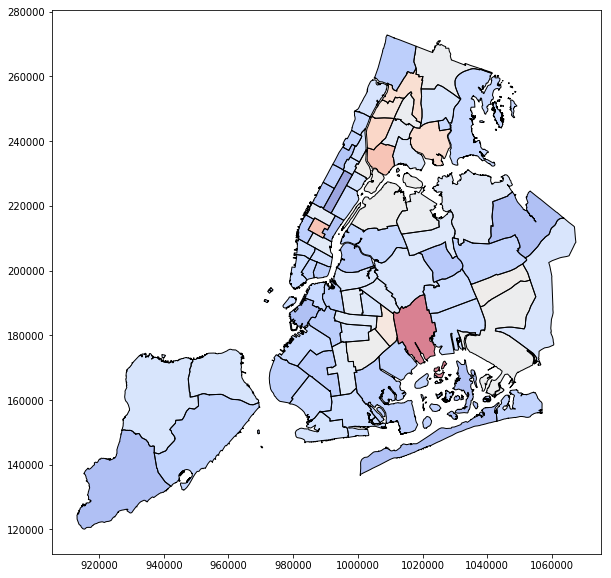

In [305]:
agg_crime.plot(
    figsize=(10,10),
    column='_2014',
    cmap=plt.cm.coolwarm
)

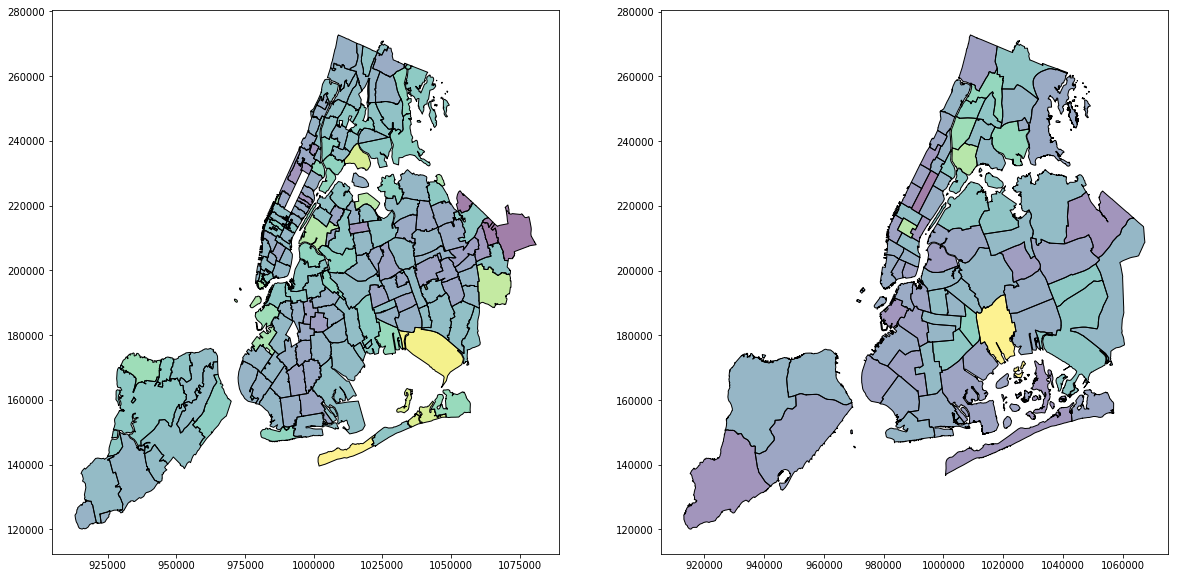

In [306]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
agg_q_score.plot(column='q_score', ax=ax[0])
agg_crime.plot(column='_2014', ax=ax[1])

In [263]:
agg_crime.crs=agg_q_score.crs

In [286]:
geopandas.sjoin(agg_crime,agg_q_score).group_by('precinct').agg({'q_score':lambda x:100-np.mean(x)})

ArgumentError: argument 2: <class 'TypeError'>: wrong type

In [280]:
agg_q_score.head()

Exception ignored in: <bound method Collection.__del__ of <open Collection '/home/nkrishna/agg_q_score.json:OgrGeoJSON', mode 'w' at 0x7fa9482c2978>>
Traceback (most recent call last):
  File "/opt/anaconda/lib/python3.6/site-packages/fiona/collection.py", line 422, in __del__
    self.__exit__(None, None, None)
  File "/opt/anaconda/lib/python3.6/site-packages/fiona/collection.py", line 417, in __exit__
    self.close()
  File "/opt/anaconda/lib/python3.6/site-packages/fiona/collection.py", line 401, in close
    self.flush()
  File "/opt/anaconda/lib/python3.6/site-packages/fiona/collection.py", line 390, in flush
    if self.session is not None and self.session.get_length() > 0:
  File "fiona/ogrext.pyx", line 479, in fiona.ogrext.Session.get_length (fiona/ogrext.c:9611)
ValueError: Null layer


,bcode,geometry,note,q_score
zcta,,,,
10001,36061,"POLYGON ((983229.2383424834 211922.5816751101,...",None,24.404568
10002,36061,"POLYGON ((985096.3850784544 198703.5457405522,...",None,25.463326
10003,36061,"POLYGON ((986450.4858028748 203647.5975069208,...",None,26.921424
10004,36061,"(POLYGON ((976856.663963466 189102.0183191186,...",None,21.043429
10005,36061,"POLYGON ((981746.6308157594 196240.0595342411,...",None,22.474183


In [284]:
agg_q_score.reset_index()[['zcta','q_score']].to_csv('agg_q_score.csv')

In [285]:
pd.read_csv('agg_q_score.csv')

,Unnamed: 0,zcta,q_score
0,0,10001,24.404568
1,1,10002,25.463326
2,2,10003,26.921424
3,3,10004,21.043429
4,4,10005,22.474183
5,5,10006,22.984866
6,6,10007,25.113669
7,7,10009,25.587563
8,8,10010,25.095139
9,9,10011,26.372725
